In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    brier_score_loss
)
from sklearn.calibration import calibration_curve


# Outline: 
- EDA
- Feature Importance
- PSI?
- Feature Engineering?
- Feature Selection
- Visualizations?
- Modeling
  - Train Test Split Cross Validation
  - Hyperparameter tuning
- Evaluate model
- Save model

In [2]:
from xgboost import XGBClassifier

dataset = pd.read_csv('data.csv')

target_col = 'Bankrupt?'

dataset

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [3]:
## This is an important number. It reflects the overall default rate across the dataset 
dataset[target_col].mean()

0.03226279513125092

In [4]:
possible_features = dataset.columns.difference([target_col])

X = dataset[possible_features]
y = dataset[target_col]



In [5]:
import numpy as np

corr_matrix = X.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > 0.7)]
X = X.drop(columns=to_drop)
print("Removed features:", to_drop)


Removed features: [' Cash Flow Per Share', ' Cash Flow to Total Assets', ' Cash Reinvestment %', ' Continuous interest rate (after tax)', ' Current Liabilities/Equity', ' Current Liability to Equity', ' Current Liability to Liability', ' Debt ratio %', ' Equity to Long-term Liability', ' Inventory and accounts receivable/Net value', ' Liability to Equity', " Net Income to Stockholder's Equity", ' Net Value Per Share (B)', ' Net Value Per Share (C)', ' Net profit before tax/Paid-in capital', ' Net worth/Assets', ' Operating Funds to Liability', ' Operating Gross Margin', ' Operating Profit Per Share (Yuan ¥)', ' Operating Profit Rate', ' Operating profit/Paid-in capital', ' Per Share Net profit before tax (Yuan ¥)', ' Persistent EPS in the Last Four Seasons', ' Pre-tax net Interest Rate', ' Quick Assets/Total Assets', ' ROA(A) before interest and % after tax', ' ROA(B) before interest and depreciation after tax', ' ROA(C) before interest and depreciation before interest', ' Realized Sal

In [6]:
# Splitting data for feature importance analysis
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [7]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

model = xgb.train(params, dtrain, num_boost_round=100)

# Measures the average improvement in model accuracy each time a feature is used in a split.
feature_importance = pd.DataFrame({
    'Feature': model.get_score(importance_type="gain").keys(),
    'Importance': model.get_score(importance_type="gain").values()}
)
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

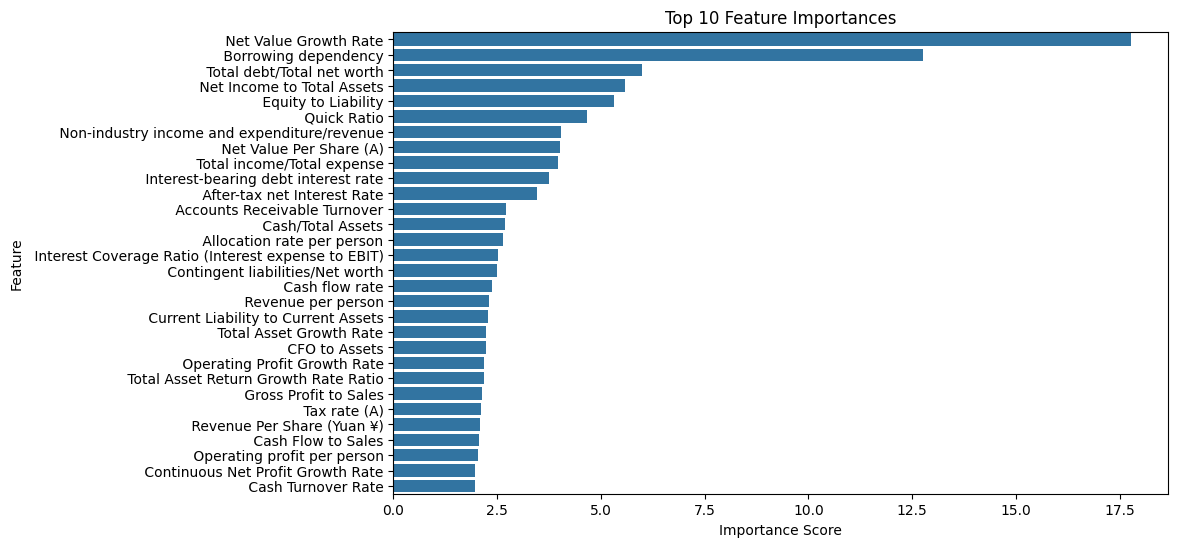

Text(0, 0.5, 'Feature')

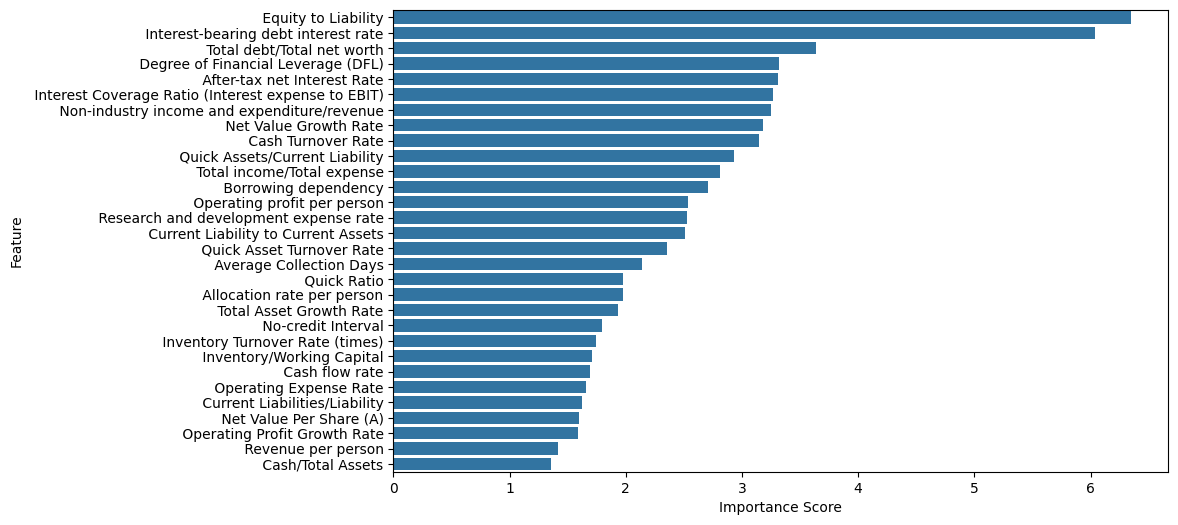

In [8]:
NUM_FEATS = 30

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.Importance[:NUM_FEATS], y=feature_importance.Feature[:NUM_FEATS])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()

cat_model = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss', verbose=0)
cat_model.fit(X_train, y_train)


cat_feature_importance = cat_model.get_feature_importance()
cat_feature_names = X_train.columns


cat_importance_df = pd.DataFrame({'Feature': cat_feature_names, 'Importance': cat_feature_importance})
cat_importance_df = cat_importance_df.sort_values(by='Importance', ascending=False)

NUM_FEATS = 30
plt.figure(figsize=(10, 6))
sns.barplot(x=cat_importance_df.Importance[:NUM_FEATS], y=cat_importance_df.Feature[:NUM_FEATS])
plt.xlabel("Importance Score")
plt.ylabel("Feature")

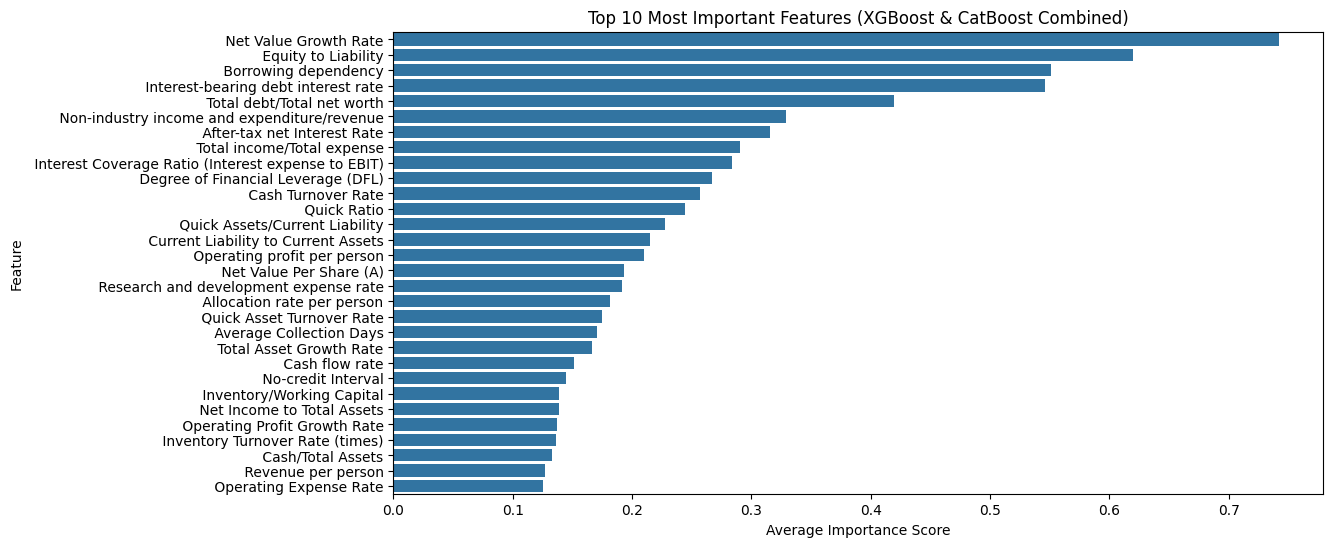

In [9]:
importance_df = pd.merge(cat_importance_df,feature_importance, on='Feature', suffixes=('_cat','_xgb'))

# Normalize using MinMaxScaler
scaler = MinMaxScaler()
importance_df[['Importance_cat', 'Importance_xgb']] = scaler.fit_transform(
    importance_df[['Importance_cat', 'Importance_xgb']]
)

importance_df['Avg_Importance'] = importance_df[['Importance_cat', 'Importance_xgb']].mean(axis=1)

importance_df = importance_df.sort_values(by="Avg_Importance", ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df.Avg_Importance[:NUM_FEATS], y=importance_df.Feature[:NUM_FEATS])
plt.xlabel("Average Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features (XGBoost & CatBoost Combined)")
plt.show()

In [10]:
NUM_TOP_FEATURES = 30  # Change as needed
top_features = importance_df['Feature'].head(NUM_TOP_FEATURES).tolist()

X_top = X[top_features]

X_train, X_temp, y_train, y_temp = train_test_split(
    X_top, y, test_size=0.4, stratify=y, random_state=42
)
X_test, X_oos, y_test, y_oos = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [11]:
# Train an XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=100,
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

/Users/aasibipin/.pyenv/versions/3.10.16/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [20]:
import warnings
warnings.filterwarnings("ignore")


In [21]:
# Method 2:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100, 150, 200]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)
print("Best ROC AUC score:", random_search.best_score_)

model = random_search.best_estimator_


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/aasibipin/.pyenv/versions/3.10.16/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aasibipin/.pyenv/versions/3.10.16/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aasibipin/.pyenv/versions/3.10.16/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:53:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/aasibipin/.pyenv/versions/3.10.16/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [16:53:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_lab

Best parameters: {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best ROC AUC score: 0.9347580180298962


In [22]:
# Evaluate on the Test set
y_test_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = model.predict(X_test)

Test set evaluation:
ROC AUC: 0.9555440771349862
PR AUC: 0.5173572109358338
Brier Score: 0.021338186177050886
Confusion Matrix:
 [[1315    5]
 [  32   12]]


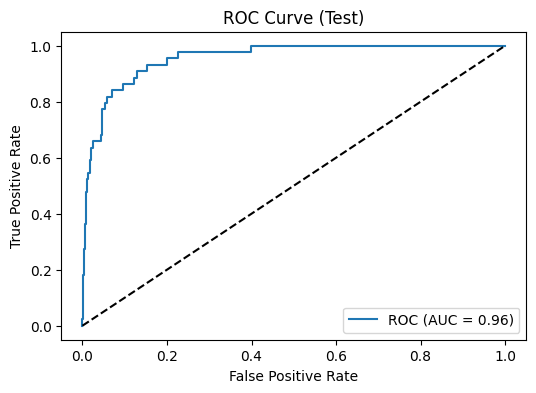

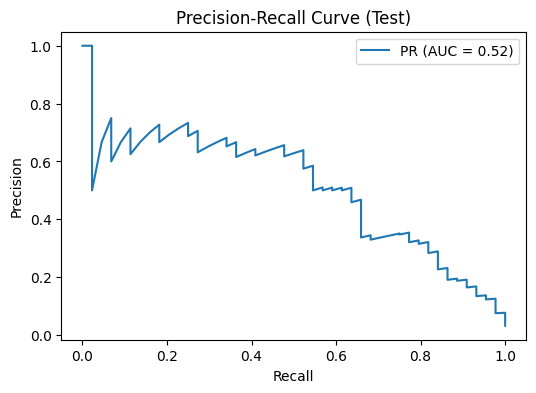

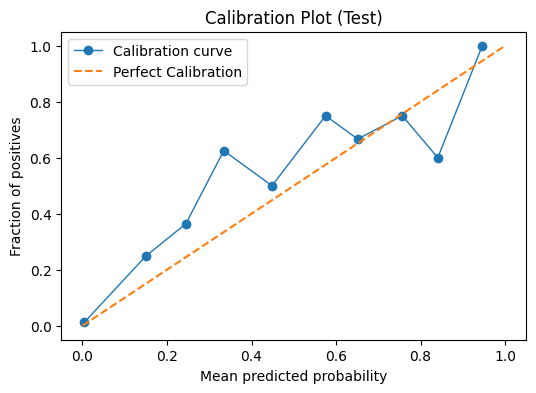


OOS set evaluation:
ROC AUC: 0.943595041322314
PR AUC: 0.43027997692592396
Brier Score: 0.0241540400225307
Confusion Matrix:
 [[1313    7]
 [  33   11]]


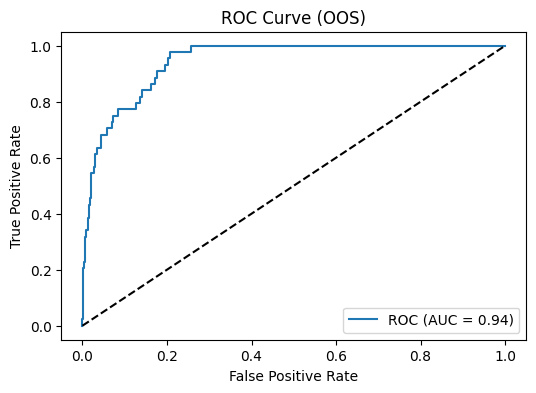

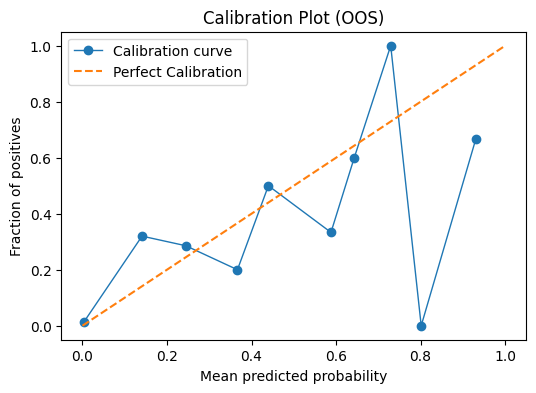

In [16]:
roc_auc_test = roc_auc_score(y_test, y_test_proba)
pr_auc_test = average_precision_score(y_test, y_test_proba)
brier_test = brier_score_loss(y_test, y_test_proba)
cm_test = confusion_matrix(y_test, y_test_pred)

print("Test set evaluation:")
print("ROC AUC:", roc_auc_test)
print("PR AUC:", pr_auc_test)
print("Brier Score:", brier_test)
print("Confusion Matrix:\n", cm_test)

# ROC AUC plot (Test)
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test)")
plt.legend()
plt.show()

# Precision-Recall curve (Test)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f'PR (AUC = {pr_auc_test:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.legend()
plt.show()

# Calibration plot (Test)
prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot (Test)")
plt.legend()
plt.show()

# Evaluate on the OOS set (similar metrics)
y_oos_proba = model.predict_proba(X_oos)[:, 1]
y_oos_pred = model.predict(X_oos)

roc_auc_oos = roc_auc_score(y_oos, y_oos_proba)
pr_auc_oos = average_precision_score(y_oos, y_oos_proba)
brier_oos = brier_score_loss(y_oos, y_oos_proba)
cm_oos = confusion_matrix(y_oos, y_oos_pred)

print("\nOOS set evaluation:")
print("ROC AUC:", roc_auc_oos)
print("PR AUC:", pr_auc_oos)
print("Brier Score:", brier_oos)
print("Confusion Matrix:\n", cm_oos)

# ROC AUC plot (OOS)
fpr, tpr, _ = roc_curve(y_oos, y_oos_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_oos:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (OOS)")
plt.legend()
plt.show()

# Calibration plot (OOS)
prob_true, prob_pred = calibration_curve(y_oos, y_oos_proba, n_bins=10)
plt.figure(figsize=(6, 4))
plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label='Calibration curve')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot (OOS)")
plt.legend()
plt.show()

In [24]:
model.save_model("model.json")


In [25]:
model.feature_names_in_

array([' Net Value Growth Rate', ' Equity to Liability',
       ' Borrowing dependency', ' Interest-bearing debt interest rate',
       ' Total debt/Total net worth',
       ' Non-industry income and expenditure/revenue',
       ' After-tax net Interest Rate', ' Total income/Total expense',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Degree of Financial Leverage (DFL)', ' Cash Turnover Rate',
       ' Quick Ratio', ' Quick Assets/Current Liability',
       ' Current Liability to Current Assets',
       ' Operating profit per person', ' Net Value Per Share (A)',
       ' Research and development expense rate',
       ' Allocation rate per person', ' Quick Asset Turnover Rate',
       ' Average Collection Days', ' Total Asset Growth Rate',
       ' Cash flow rate', ' No-credit Interval',
       ' Inventory/Working Capital', ' Net Income to Total Assets',
       ' Operating Profit Growth Rate',
       ' Inventory Turnover Rate (times)', ' Cash/Total Assets',
   

In [26]:
# Test inference

In [39]:
X_oos

,Net Value Growth Rate,Equity to Liability,Borrowing dependency,Interest-bearing debt interest rate,Total debt/Total net worth,Non-industry income and expenditure/revenue,After-tax net Interest Rate,Total income/Total expense,Interest Coverage Ratio (Interest expense to EBIT),Degree of Financial Leverage (DFL),...,Total Asset Growth Rate,Cash flow rate,No-credit Interval,Inventory/Working Capital,Net Income to Total Assets,Operating Profit Growth Rate,Inventory Turnover Rate (times),Cash/Total Assets,Revenue per person,Operating Expense Rate
1534,0.000871,0.021482,0.379579,0.000658,0.011730,0.302385,0.808718,0.002083,0.563721,0.026557,...,1.090870e-04,0.462693,0.623175,0.276896,0.764491,0.848138,1.016509e-04,0.048216,0.003152,4.409220e-04
4090,0.000437,0.027259,0.376996,0.000723,0.007704,0.303518,0.809316,0.002246,0.566110,0.027037,...,4.910000e+09,0.466214,0.623833,0.277351,0.798904,0.848004,9.400000e+09,0.018707,0.051693,9.760000e+09
3534,0.000663,0.044983,0.369882,0.000413,0.003706,0.303532,0.809530,0.002484,0.565177,0.026795,...,1.300256e-04,0.472409,0.624048,0.277149,0.858368,0.849787,9.000000e+09,0.430226,0.021474,2.195937e-04
1413,0.000414,0.054653,0.371565,0.000743,0.002870,0.303117,0.808956,0.002067,0.564855,0.026731,...,6.080000e+09,0.470220,0.623733,0.277487,0.751339,0.847790,2.600000e+09,0.034456,0.003992,3.393931e-04
6549,0.000424,0.046342,0.369637,0.000000,0.003562,0.303448,0.809230,0.002175,0.565158,0.026791,...,6.330000e+09,0.449935,0.624398,0.276975,0.784835,0.845154,1.910000e+07,0.260775,0.005567,2.694330e-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6455,0.000457,0.024997,0.377157,0.000150,0.008905,0.303460,0.809318,0.002243,0.566754,0.027281,...,7.390000e+09,0.458942,0.623664,0.277553,0.797761,0.848005,3.630000e+09,0.072903,0.021021,1.761144e-04
6548,0.000479,0.047904,0.370232,0.000205,0.003409,0.303674,0.809427,0.002503,0.565192,0.026798,...,6.650000e+09,0.466293,0.624410,0.277062,0.830716,0.848017,2.206893e-04,0.393126,0.019749,9.660000e+09
5692,0.000573,0.031303,0.371651,0.000279,0.006200,0.303656,0.809441,0.002763,0.565228,0.026806,...,9.850000e+08,0.470033,0.625038,0.277046,0.840692,0.847999,3.429761e-04,0.239749,0.120421,4.730000e+09
3205,0.000480,0.025414,0.379195,0.000454,0.008657,0.303287,0.809233,0.002155,0.559376,0.026226,...,6.740000e+09,0.470636,0.623761,0.276916,0.790782,0.848124,1.949900e-03,0.066300,0.005158,1.135550e-04


In [23]:
X_oos.head(10).to_csv('inference_test.csv')

In [34]:
model = xgb.Booster()
model.load_model("model.json")

In [35]:
final_features = [
    " Net Value Growth Rate",
    " Equity to Liability",
    " Borrowing dependency",
    " Interest-bearing debt interest rate",
    " Total debt/Total net worth",
    " Non-industry income and expenditure/revenue",
    " After-tax net Interest Rate",
    " Total income/Total expense",
    " Interest Coverage Ratio (Interest expense to EBIT)",
    " Degree of Financial Leverage (DFL)",
    " Cash Turnover Rate",
    " Quick Ratio",
    " Quick Assets/Current Liability",
    " Current Liability to Current Assets",
    " Operating profit per person",
    " Net Value Per Share (A)",
    " Research and development expense rate",
    " Allocation rate per person",
    " Quick Asset Turnover Rate",
    " Average Collection Days",
    " Total Asset Growth Rate",
    " Cash flow rate",
    " No-credit Interval",
    " Inventory/Working Capital",
    " Net Income to Total Assets",
    " Operating Profit Growth Rate",
    " Inventory Turnover Rate (times)",
    " Cash/Total Assets",
    " Revenue per person",
    " Operating Expense Rate",
]

In [36]:
df = pd.read_csv('inference_test.csv')
print(df.columns)

missing = set(final_features) - set(df.columns)
if missing:
    print({"error": f"Missing columns in CSV: {missing}"})

df_final = df[final_features]
predictions = model.predict(df_final)


Index(['Unnamed: 0', ' Net Value Growth Rate', ' Equity to Liability',
       ' Borrowing dependency', ' Interest-bearing debt interest rate',
       ' Total debt/Total net worth',
       ' Non-industry income and expenditure/revenue',
       ' After-tax net Interest Rate', ' Total income/Total expense',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Degree of Financial Leverage (DFL)', ' Cash Turnover Rate',
       ' Quick Ratio', ' Quick Assets/Current Liability',
       ' Current Liability to Current Assets', ' Operating profit per person',
       ' Net Value Per Share (A)', ' Research and development expense rate',
       ' Allocation rate per person', ' Quick Asset Turnover Rate',
       ' Average Collection Days', ' Total Asset Growth Rate',
       ' Cash flow rate', ' No-credit Interval', ' Inventory/Working Capital',
       ' Net Income to Total Assets', ' Operating Profit Growth Rate',
       ' Inventory Turnover Rate (times)', ' Cash/Total Assets',
   

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [38]:
model = XGBClassifier()
model.load_model("model.json")

df = pd.read_csv('inference_test.csv')
print(df.columns)

missing = set(final_features) - set(df.columns)
if missing:
    print({"error": f"Missing columns in CSV: {missing}"})

df_final = df[final_features]
predictions = model.predict(df_final)


Index(['Unnamed: 0', ' Net Value Growth Rate', ' Equity to Liability',
       ' Borrowing dependency', ' Interest-bearing debt interest rate',
       ' Total debt/Total net worth',
       ' Non-industry income and expenditure/revenue',
       ' After-tax net Interest Rate', ' Total income/Total expense',
       ' Interest Coverage Ratio (Interest expense to EBIT)',
       ' Degree of Financial Leverage (DFL)', ' Cash Turnover Rate',
       ' Quick Ratio', ' Quick Assets/Current Liability',
       ' Current Liability to Current Assets', ' Operating profit per person',
       ' Net Value Per Share (A)', ' Research and development expense rate',
       ' Allocation rate per person', ' Quick Asset Turnover Rate',
       ' Average Collection Days', ' Total Asset Growth Rate',
       ' Cash flow rate', ' No-credit Interval', ' Inventory/Working Capital',
       ' Net Income to Total Assets', ' Operating Profit Growth Rate',
       ' Inventory Turnover Rate (times)', ' Cash/Total Assets',
   